<a href="https://www.kaggle.com/code/danush121/ml-aat?scriptVersionId=190318852" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Handwriting Recognition using CNN + RNN


## Loading Python Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy as sp
import random
import warnings
import string
import datetime
warnings.filterwarnings("ignore")
%matplotlib inline

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

## Loading, Viewing Dataset



In [2]:
train_name = pd.read_csv('../input/handwriting-recognition/written_name_train_v2.csv')
test_name = pd.read_csv('../input/handwriting-recognition/written_name_test_v2.csv')
val_name = pd.read_csv('../input/handwriting-recognition/written_name_validation_v2.csv')

In [3]:
train_name.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [4]:
train_name.describe()

,FILENAME,IDENTITY
count,330961,330396
unique,330961,100539
top,TRAIN_00001.jpg,THOMAS
freq,1,1825


In [5]:
test_name.describe()

,FILENAME,IDENTITY
count,41370,41300
unique,41370,20279
top,TEST_0001.jpg,THOMAS
freq,1,227


In [6]:
train_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [7]:
test_name.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41370 entries, 0 to 41369
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   FILENAME  41370 non-null  object
 1   IDENTITY  41300 non-null  object
dtypes: object(2)
memory usage: 646.5+ KB


In [8]:
train_name.shape

(330961, 2)

In [9]:
test_name.shape

(41370, 2)

In [10]:
val_name.shape

(41370, 2)

In [11]:
train_name.dtypes

FILENAME    object
IDENTITY    object
dtype: object

In [12]:
train_name.columns

Index(['FILENAME', 'IDENTITY'], dtype='object')

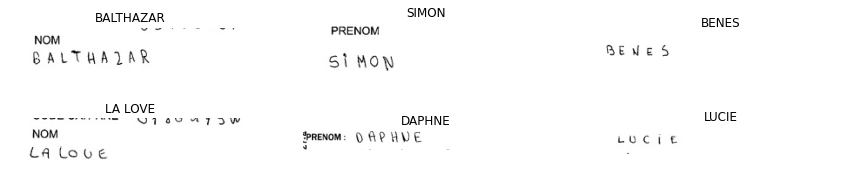

In [13]:
plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '../input/handwriting-recognition/train_v2/train/'+train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train_name.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Data Cleaning


In [14]:
print("Number of NaNs in the train dataset is: ", train_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the validation dataset is: ", val_name['IDENTITY'].isnull().sum())
print("Number of NaNs in the test dataset is: ", test_name['IDENTITY'].isnull().sum())

Number of NaNs in the train dataset is:  565
Number of NaNs in the validation dataset is:  78
Number of NaNs in the test dataset is:  70


In [15]:
train_name.dropna(axis=0, inplace=True)
val_name.dropna(axis=0, inplace=True)
test_name.dropna(axis=0, inplace=True)

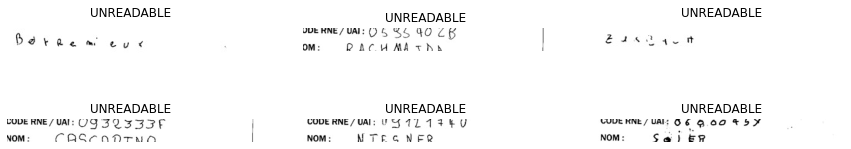

In [16]:
unreadable = train_name[train_name['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop = True)

plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '../input/handwriting-recognition/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [17]:
train_name = train_name[train_name['IDENTITY'] != 'UNREADABLE']
val_name = val_name[val_name['IDENTITY'] != 'UNREADABLE']
test_name = test_name[test_name['IDENTITY'] != 'UNREADABLE']

In [18]:
train_name['IDENTITY'] = train_name['IDENTITY'].str.upper()
val_name['IDENTITY'] = val_name['IDENTITY'].str.upper()
test_name['IDENTITY'] = test_name['IDENTITY'].str.upper()

In [19]:
train_name.reset_index(inplace = True, drop = True)
val_name.reset_index(inplace = True, drop = True)
test_name.reset_index(inplace = True, drop = True)

## Image Preprocessing


In [20]:
def image_processing(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop if image dimension exceeds the said criteria
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
        
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

## Training

In [21]:
train_size = 30000
val_size = 3000
test_size = 3000
train_x = []
val_x = []
test_x = []

for i in range(train_size):
    img_dir = '../input/handwriting-recognition/train_v2/train/' + train_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    train_x.append(image)
    
for i in range(val_size):
    img_dir = '../input/handwriting-recognition/validation_v2/validation/' + val_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    val_x.append(image)
    
for i in range(test_size):
    img_dir = '../input/handwriting-recognition/test_v2/test/' + test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = image_processing(image)
    image = image/255.
    test_x.append(image)
    
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
val_x = np.array(val_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

## Character processing



In [22]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 
num_characters = len(alphabets) + 1 
num_of_timestamps = 64 

def name_to_num(name):
    name_num = []
    for ch in name:
        name_num.append(alphabets.find(ch))
    return np.array(name_num)

def num_to_name(num):
    name = ""
    for ch in num:
        if ch == -1: # CTC blank
            break
        else:
            name += alphabets[ch]
    return name

In [23]:
train_y = np.ones([train_size, max_str_len]) * -1
train_name_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_name_len[i] = len(train_name.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train_name.loc[i, 'IDENTITY'])] = name_to_num(train_name.loc[i, 'IDENTITY'])

val_y = np.ones([val_size, max_str_len]) * -1
val_name_len = np.zeros([val_size, 1])
val_input_len = np.ones([val_size, 1]) * (num_of_timestamps-2)
val_output = np.zeros([val_size])

for i in range(val_size):
    val_name_len[i] = len(val_name.loc[i, 'IDENTITY'])
    val_y[i, 0:len(val_name.loc[i, 'IDENTITY'])] = name_to_num(val_name.loc[i, 'IDENTITY'])

test_y = np.ones([test_size, max_str_len]) * -1
test_name_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_name_len[i] = len(test_name.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test_name.loc[i, 'IDENTITY'])] = name_to_num(test_name.loc[i, 'IDENTITY'])

## Building a hybrid CNN + RNN model

CNN(3 layers)
RNN(2 Layers)

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, Dense, Bidirectional, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

def ctc_lambda_func(args):
    y_pred, names, input_length, name_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(names, y_pred, input_length, name_length)

input_data = Input(shape=(256, 64, 1), name='input')

# CNN
inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2,2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1,2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name='lstm2')(inner)

# Output
inner = Dense(num_characters, kernel_initializer='he_normal', name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)


names = Input(name='gtruth_names', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
name_length = Input(name='name_length', shape=[1], dtype='int64')


ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, names, input_length, name_length])
model_final = Model(inputs=[input_data, names, input_length, name_length], outputs=ctc_loss)
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(learning_rate=0.0001))


## Training the model



In [25]:
model_final.fit(x = [train_x, train_y, train_input_len, train_name_len], y=train_output, validation_data = ([val_x, val_y, val_input_len, val_name_len], val_output), epochs=60, batch_size=128)

Epoch 1/60
235/235 [==============================] - 50s 156ms/step - loss: 24.3303 - val_loss: 20.5783
Epoch 2/60
235/235 [==============================] - 34s 146ms/step - loss: 20.1501 - val_loss: 20.0351
Epoch 3/60
235/235 [==============================] - 34s 147ms/step - loss: 19.7715 - val_loss: 19.5806
Epoch 4/60
235/235 [==============================] - 34s 145ms/step - loss: 19.2385 - val_loss: 18.7834
Epoch 5/60
235/235 [==============================] - 34s 145ms/step - loss: 18.0069 - val_loss: 17.2937
Epoch 6/60
235/235 [==============================] - 34s 145ms/step - loss: 16.1669 - val_loss: 14.7930
Epoch 7/60
235/235 [==============================] - 34s 145ms/step - loss: 13.5733 - val_loss: 11.5907
Epoch 8/60
235/235 [==============================] - 34s 145ms/step - loss: 10.3157 - val_loss: 8.0580
Epoch 9/60
235/235 [==============================] - 34s 145ms/step - loss: 7.7525 - val_loss: 6.6250
Epoch 10/60
235/235 [==============================] - 34s

## validation 



In [26]:
preds = model.predict(val_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(val_size):
    prediction.append(num_to_name(decoded[i]))
    
y_true = val_name.loc[0:val_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(val_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr:
        correct += 1
        
print('Correct characters predicted: %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted: %.2f%%' %(correct*100/val_size))

Correct characters predicted: 92.05%
Correct words predicted: 77.57%


## test



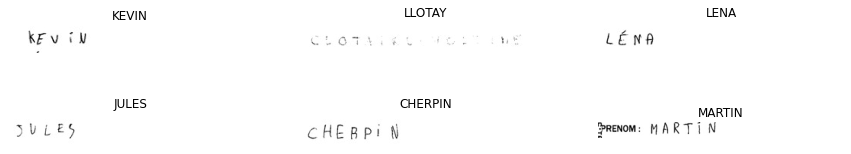

In [27]:
from tensorflow.keras.models import Model, load_model
mod=load_model("/kaggle/input/model2/keras/default/1/modelh.h5")

plt.figure(figsize=(15,10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '../input/handwriting-recognition/test_v2/test/'+test_name.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    
    image = image_processing(image)
    image = image/255.
    pred = mod.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length = np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_name(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

## Predictions

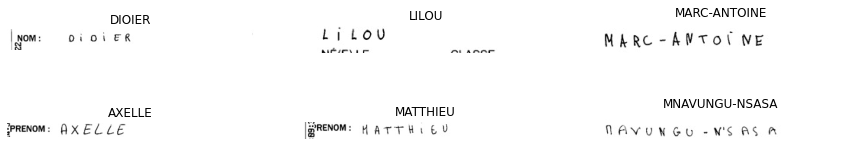

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Load the pre-trained model
mod = load_model("/kaggle/input/model2/keras/default/1/modelh.h5")

# Preprocessing function
def image_processing(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256]) * 255  # blank white image
    
    # Crop if image dimensions exceed the criteria
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
        
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

# Function to convert prediction to readable text
def num_to_name(num):
    alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
    name = ""
    for ch in num:
        if ch == -1:  # CTC blank
            break
        else:
            name += alphabets[ch]
    return name

# Path to the custom directory containing the images
custom_image_dir = '../input/handwriting-recognition/test_v2/test/'

# List all filenames in the custom directory
filenames = os.listdir(custom_image_dir)

# Create a figure for plotting
plt.figure(figsize=(15, 10))

# Iterate over the filenames and process each image
for i, filename in enumerate(filenames):
    if i >= 6:  # Display only the first 6 images
        break

    ax = plt.subplot(2, 3, i + 1)
    img_path = os.path.join(custom_image_dir, filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(image, cmap='gray')
    
    image = image_processing(image)
    image = image / 255.0
    pred = mod.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_name(decoded[0]), fontsize=12)
    plt.axis('off')

# Adjust the layout
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()

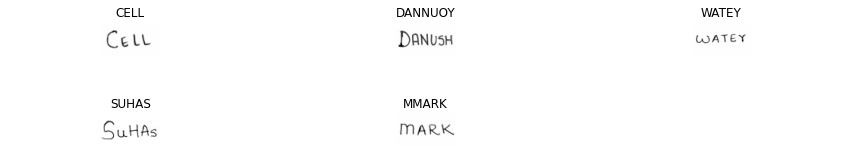

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Load the pre-trained model
mod = load_model("/kaggle/input/model2/keras/default/1/modelh.h5")

# Preprocessing function
def image_processing(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256]) * 255  # blank white image
    
    # Crop if image dimensions exceed the criteria
    if w > 256:
        img = img[:, :256]
    if h > 64:
        img = img[:64, :]
        
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

# Function to convert prediction to readable text
def num_to_name(num):
    alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
    name = ""
    for ch in num:
        if ch == -1:  # CTC blank
            break
        else:
            name += alphabets[ch]
    return name

# Path to the custom directory containing the images
custom_image_dir = '/kaggle/input/trial6/des2'

# List all filenames in the custom directory
filenames = os.listdir(custom_image_dir)

# Create a figure for plotting
plt.figure(figsize=(15, 10))

# Iterate over the filenames and process each image
for i, filename in enumerate(filenames):
    if i >= 6:  # Display only the first 6 images
        break

    ax = plt.subplot(2, 3, i + 1)
    img_path = os.path.join(custom_image_dir, filename)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    plt.imshow(image, cmap='gray')
    
    image = image_processing(image)
    image = image / 255.0
    pred = mod.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0]) * pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_name(decoded[0]), fontsize=12)
    plt.axis('off')

# Adjust the layout
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()